### Introduction: This is the Jupyter notebook to do the flowing things:

1. Read slimmed PKU Tree files to plot variables distribution

Enviroment needed for this script: HWW

(I have exported the enviroment needed for this script, assume you have `Conda` installed in your terminal, then enter `../envs/` directory, and use  `conda env create -f HWW.yml` to create the enviroment)




### Import necessary modules

In [1]:
import numpy as np
import os
import pandas as pd
import random
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from scipy import interpolate
from cycler import cycler
import uproot
import ROOT
import argparse
import glob
import json
import logging
import os
import pickle as pkl
import warnings
import hist as hist2
import pyarrow
import yaml
from hist.intervals import ratio_uncertainty
from typing import Dict, List, Union
from dataclasses import dataclass
from copy import deepcopy
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import vector

/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:257:29: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "memory_resource" [optional] {
                            ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:447:27: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/chrono.h" [optional] {
                          ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:531:41: warning: unknown attribute 'optional' [-Wignored-attributes]
  explicit module "bits_ranges_base_h" [optional] {
                                        ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:538:32: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/ranges_util.h" [optional] {
                               ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:559:40: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/uses_allo

Welcome to JupyROOT 6.28/04


### Read SlimmedTree files

In [2]:
# load the slimmedtree files using uproot
# if run on PKU cluster, use this:
CustNanoData = {
    'TT_Semilep'          : "/data/bond/zhaoyz/Pheno/slimmedtree/v6/set_v6.root",
}
files = { }
for typefile in CustNanoData:
    files[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree"})

In [3]:
files["TT_Semilep"]

<Array [{PT_j: 203, ... hbq: 6.84e-08}] type='1364114 * {"PT_j": float32, "Eta_j...'>

In [4]:
isTight = (files["TT_Semilep"]["n_b_tight"] == 2)

In [5]:
isTight

<Array [False, False, True, ... False, False] type='1364114 * bool'>

In [6]:
valid_delta_r_tight = (files["TT_Semilep"]["delta_r_tight"] > -99)

In [7]:
tight_dr = files["TT_Semilep"][files["TT_Semilep"]["n_b_tight"] == 2]["delta_r_tight"]

In [8]:
tight_dr

<Array [2.96, 2.84, 1.03, ... 1.37, 3.52, 1.02] type='245612 * float64'>

In [9]:
np.sum((tight_dr <= 0.2))

0

In [10]:
np.sum((tight_dr >= 0.2) & (tight_dr <= 0.4))

1345

In [11]:
np.sum((tight_dr >= 0.4) & (tight_dr <= 0.6))

23370

In [12]:
np.sum((tight_dr > 0.6) & (tight_dr < 0.8))

11644

In [13]:
valid_delta_r_tight

<Array [False, False, True, ... False, False] type='1364114 * bool'>

In [14]:
ischeck = np.sum(valid_delta_r_tight == isTight)

In [15]:
ischeck

1364114

In [16]:
MAIN_DIR = ".."

plot_dir = f"{MAIN_DIR}/plots/distribution/30Sep2024"
_ = os.system(f"mkdir -p {plot_dir}")

### Split to matching

In [17]:
#gen-matching results: bkg

files["b_top_matched_bqq"] = files["TT_Semilep"][(files["TT_Semilep"]["top_matched_bqq"] == 1) & (files["TT_Semilep"]["isWcb"] == 0 )]
files["b_top_matched_bq"] = files["TT_Semilep"][(files["TT_Semilep"]["top_matched_bq"] == 1) & (files["TT_Semilep"]["isWcb"] == 0 )]
files["b_w_matched_others"] = files["TT_Semilep"][((files["TT_Semilep"]["w_matched_cd"] == 1) | (files["TT_Semilep"]["w_matched_cs"] == 1) | (files["TT_Semilep"]["w_matched_us"] == 1) | (files["TT_Semilep"]["w_matched_ud"] == 1) | (files["TT_Semilep"]["w_matched_ub"] == 1)) & (files["TT_Semilep"]["isWcb"] == 0) ]
files["b_w_matched_cb"] = files["TT_Semilep"][(files["TT_Semilep"]["w_matched_cb"] == 1) & (files["TT_Semilep"]["isWcb"] == 0)]
files["b_others"] = files["TT_Semilep"][((files["TT_Semilep"]["unmatched"] ==1) | (files["TT_Semilep"]["q_matched"] ==1) | (files["TT_Semilep"]["bb_matched"] ==1) | (files["TT_Semilep"]["b_matched_had"] ==1) | (files["TT_Semilep"]["b_matched_lep"] ==1) | (files["TT_Semilep"]["lep_b_qq"] ==1) | (files["TT_Semilep"]["lep_b_q"] ==1) | (files["TT_Semilep"]["bb_q"] ==1) | (files["TT_Semilep"]["bb_qq"] ==1)) & (files["TT_Semilep"]["isWcb"] == 0)]


files["s_top_matched_bqq"] = files["TT_Semilep"][(files["TT_Semilep"]["top_matched_bqq"]  ==1 ) & ( files["TT_Semilep"]["isWcb"] == 1)]
files["s_top_matched_bq"] = files["TT_Semilep"][(files["TT_Semilep"]["top_matched_bq"] == 1) & ( files["TT_Semilep"]["isWcb"] == 1)]
files["s_w_matched_others"] = files["TT_Semilep"][((files["TT_Semilep"]["w_matched_cd"] == 1) | (files["TT_Semilep"]["w_matched_cs"] == 1) | (files["TT_Semilep"]["w_matched_us"] == 1) | (files["TT_Semilep"]["w_matched_ud"] == 1) | (files["TT_Semilep"]["w_matched_ub"] == 1)) & (files["TT_Semilep"]["isWcb"] == 1) ]
files["s_w_matched_cb"] = files["TT_Semilep"][(files["TT_Semilep"]["w_matched_cb"] == 1) & ( files["TT_Semilep"]["isWcb"] ==1 )]
files["s_others"] = files["TT_Semilep"][((files["TT_Semilep"]["unmatched"] ==1) | (files["TT_Semilep"]["q_matched"] ==1) | (files["TT_Semilep"]["bb_matched"] ==1) | (files["TT_Semilep"]["b_matched_had"] ==1) | (files["TT_Semilep"]["b_matched_lep"] ==1) | (files["TT_Semilep"]["lep_b_qq"] ==1) | (files["TT_Semilep"]["lep_b_q"] ==1) | (files["TT_Semilep"]["bb_q"] ==1) | (files["TT_Semilep"]["bb_qq"] ==1)) & (files["TT_Semilep"]["isWcb"] == 1)]

files["TotalSignal"] = files["TT_Semilep"][( files["TT_Semilep"]["isWcb"] ==1 )]



In [18]:
files["TT_Semilep"]

<Array [{PT_j: 203, ... hbq: 6.84e-08}] type='1364114 * {"PT_j": float32, "Eta_j...'>

### Get taggers

In [19]:
def get_tagger(files, alpha = 0, beta = 0, name = ""):
    for sample in files:
        print(f"add tagger for {sample}")
        files[sample][name] = files[sample]["hbc"] / (files[sample]["hbc"] + alpha * files[sample]["qcd"] + beta * files[sample]["hbq"])

In [20]:
get_tagger(files, alpha = 1, beta = 0, name = "HbcvsQCD")

add tagger for TT_Semilep
add tagger for b_top_matched_bqq
add tagger for b_top_matched_bq
add tagger for b_w_matched_others
add tagger for b_w_matched_cb
add tagger for b_others
add tagger for s_top_matched_bqq
add tagger for s_top_matched_bq
add tagger for s_w_matched_others
add tagger for s_w_matched_cb
add tagger for s_others
add tagger for TotalSignal


In [21]:
get_tagger(files, alpha = 0, beta = 1, name = "HbcvsHbq")

add tagger for TT_Semilep
add tagger for b_top_matched_bqq
add tagger for b_top_matched_bq
add tagger for b_w_matched_others
add tagger for b_w_matched_cb
add tagger for b_others
add tagger for s_top_matched_bqq
add tagger for s_top_matched_bq
add tagger for s_w_matched_others
add tagger for s_w_matched_cb
add tagger for s_others
add tagger for TotalSignal


### output all the variables for which we can make plots

In [22]:
files["TotalSignal"].fields

['PT_j',
 'Eta_j',
 'Phi_j',
 'Mass_j',
 'Mass_j_sd',
 'n_b_tight',
 'n_b_medium',
 'n_b_loose',
 'n_b_ideal',
 'delta_r_tight',
 'delta_r_medium',
 'delta_r_loose',
 'delta_r_ideal',
 'delta_r1_Wcb_tight',
 'delta_r1_Wcb_medium',
 'delta_r1_Wcb_loose',
 'delta_r1_Wcb_ideal',
 'delta_r2_Wcb_tight',
 'delta_r2_Wcb_medium',
 'delta_r2_Wcb_loose',
 'delta_r2_Wcb_ideal',
 'delta_eta_tight',
 'delta_eta_medium',
 'delta_eta_loose',
 'delta_eta_ideal',
 'delta_prod_eta_tight',
 'delta_prod_eta_medium',
 'delta_prod_eta_loose',
 'delta_prod_eta_ideal',
 'top_matched_bqq',
 'top_matched_bq',
 'lep_b_qq',
 'lep_b_q',
 'w_matched_cd',
 'w_matched_cs',
 'w_matched_cb',
 'w_matched_ud',
 'w_matched_ub',
 'w_matched_us',
 'b_matched_had',
 'b_matched_lep',
 'bb_matched',
 'bb_q',
 'bb_qq',
 'q_matched',
 'unmatched',
 'isWcb',
 'lep_b_in',
 'had_b_in',
 'NAK8',
 'NAK4',
 'hbcvsqcd',
 'hbc',
 'qcd',
 'hbq',
 'HbcvsQCD',
 'HbcvsHbq']

### plot setting, error setting, histogram setting

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=True):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])


# function to find the optimal region with S/sqrt(B)
# actually used
def optimalcut(shist, bhist):
    n_bins = len(shist)
    best_lower = None
    best_upper = None
    best_s_sqrt_b = 0

    for lower in range(n_bins):
        for upper in range(lower+1, n_bins+1):
            s = np.sum(shist[lower:upper])
            b = np.sum(bhist[lower:upper])
            s_sqrt_b = s / np.sqrt(b + 0.001)

            if s_sqrt_b > best_s_sqrt_b:
                best_lower = lower
                best_upper = upper
                best_s_sqrt_b = s_sqrt_b

    return best_lower, best_upper, best_s_sqrt_b

def optimalcut_oneside(shist, bhist, epsilon = 0.01):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist)
    best_cut = 0
    best_s_sqrt_b = 0

    for cut in range(n_bins):
        s = np.sum(shist[cut:])
        b = np.sum(bhist[cut:])
        s_sqrt_b = s / np.sqrt(b + epsilon)
        if s_sqrt_b > best_s_sqrt_b:
            best_cut = cut
            best_s_sqrt_b = s_sqrt_b
        
    return best_cut, best_s_sqrt_b

def optimalcut_mid_combine(shist1, shist2, bhist, epsilon = 1):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist1)
    best_cut = 0
    best_combined_sig_two_side = 0

    for cut in range(n_bins):
        s_right_side = np.sum(shist2[cut:])
        b_right_side = np.sum(bhist[cut:])
        s_left_side = np.sum(shist1[:cut])
        b_left_side = np.sum(bhist[:cut])
        s_sqrt_b_right_side = s_right_side / np.sqrt(b_right_side + epsilon)
        s_sqrt_b_left_side = s_left_side / np.sqrt(b_left_side + epsilon)
        combined_sig_two_side = np.sqrt((s_sqrt_b_right_side)**2 + (s_sqrt_b_left_side)**2)
        if combined_sig_two_side > best_combined_sig_two_side:
            best_cut = cut
            best_combined_sig_two_side = combined_sig_two_side
        
    return best_cut, best_combined_sig_two_side


### define main plots function

In [34]:
from matplotlib.cm import get_cmap
plt.style.use(hep.style.ROOT)
def makeplots(arrays, plot_name: str, x_name: str, region = 'PS',othertext = "", year='2018', nbins=20, x_min=0, x_max=2000, density=False, overflow=False, underflow=False, fraction_log=False,log = False,blind = True, blindMC = False, nametext = "",optimal_cut = True, deco = False,postfit_files = ""):
    LUMI = {"2016APV": 19.52, "2016": 16.81, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/nbins
    ## canvas initializing
    f = plt.figure(figsize=(10, 12.5))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4,  1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    # hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    # Ratio panel
    # ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[1])
    # ax1.grid()
    ax2.grid()    
    # analyze
    stacked = {'h': {}, 'var': {}} 
    individual = {'h': {}, 'var': {}}
    BKG = ["b_top_matched_bqq","b_top_matched_bq","b_w_matched_others","b_others","b_w_matched_cb"]
    name_dict_sig = [
        #sig
        "TotalSignal"           ,
        "s_top_matched_bqq"     ,
        "s_top_matched_bq"      ,
        "s_w_matched_others"    ,
        "s_w_matched_cb"        ,
        "s_others"           ,

    ]
    for (k,v) in arrays.items():
        if (k not in BKG) and (k not in name_dict_sig) : continue
        hist = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        hist.fill(values, weight = 1.0) #weight to be added in the future
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var        
    #plot
    SIG_COLOR={'TotalSignal': 'black'}
    SIG_DECO_COLOR = {'TotalSignal': 'black',"s_w_matched_cb":"blue","s_top_matched_bqq":"pink","s_top_matched_bq":"gray","s_w_matched_others":"green","s_others":"orange"}
    # ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    if len(stacked['h'].keys())>0:
        BKG_list = ["b_top_matched_bqq","b_top_matched_bq","b_w_matched_others","b_others","b_w_matched_cb"]
        err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        # colors = ["#1f77b4", "#ff7f0e", "#2ca02c","green","#d62728"] #old color regime
        colors = ["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1"] #latest color regime according to:https://cms-analysis.docs.cern.ch/guidelines/plotting/colors/#1d-histogramstackplot
        # corresponds to Rest, WJets, TT, ST, QCD
        # colors = colors[::-1]
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list,  histtype='fill', density=density, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        print(bkg_h)
        bkg_err = np.sum(err_list ,  axis=0)
        print(bkg_err)
        bin_edges = np.linspace(x_min, x_max, nbins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        # ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
        
        #plot grey bar for systematic uncertainties
        # ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
        
        #add dashed region for systematic uncertainties
        errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 0,
            "alpha": 0.4,
            "label":"Stat. Unc.",
        }
        ax.stairs(values = bkg_h - bkg_err[0], baseline = bkg_h + bkg_err[1], edges = hist.axes[0].edges, **errps)
        
    # Scale the signal according to total BKG to make it visiable:
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["TotalSignal"])+0.000001)
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    
    
    for (k,h) in individual['h'].items():
        if k == "data": 
            #not used here
            pass
        else:  # signal
            if deco != True: #plot signal in different production mode
                if k in ["TotalSignal"]:
                    err = error_bar(h, individual['var'][k], type='mc')
                    hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=False, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
                    y = h / np.sqrt(bkg_h + 1)
                    hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=False, stack=False, ax=ax2, color=SIG_COLOR[k])
            
            else: #plot signal in signal decomposition mode
                if k not in ["ggF","VH","ttH","VBF"]:
                    frac = "(" + "%.1f"%(np.sum(h)/np.sum(individual['h']["TotalSignal"])*100)+ "%)"
                    err = error_bar(h, individual['var'][k], type='mc')
                    if k != "TotalSignal": hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+frac, histtype='step', density=False, stack=False, linewidth=2, ax=ax, color=SIG_DECO_COLOR[k])
                    else:hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=False, stack=False, linewidth=2, ax=ax, color=SIG_DECO_COLOR[k])
                    y = h / np.sqrt(bkg_h + 1)
                    hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=False, stack=False, ax=ax2, color=SIG_DECO_COLOR[k])
            
            if k == "TotalSignal": #print optimal cut information
                best_lower, best_upper, best_s_sqrt_b = optimalcut(h,bkg_h)
                print("Optimal two-side cut =",best_lower, best_upper, best_s_sqrt_b)
                best_cut, best_s_sqrt_b = optimalcut_oneside(h,bkg_h)
                print("Optimal one-side cut =",best_cut, best_s_sqrt_b) 
                # best_cut, best_combined_sig_two_side = optimalcut_mid_combine(individual['h'][r"$H^{4q}$"],individual['h'][r"$H^{lqq}$"],bkg_h)
                # print("Optimal mid-side cut = ",best_cut,best_combined_sig_two_side)
            
            if k == "TotalSignal" and optimal_cut == True:
                # cut_value_low = x_min + best_lower * (x_max - x_min)/nbins
                # ax2.axvline(x=cut_value_low, color='r', linestyle='-')
                # remove those arrows
                # ax2.annotate('', xy=(cut_value_low, ax2.get_ylim()[1]), xytext=(cut_value_low - (x_max - x_min)/20 , ax2.get_ylim()[1]),arrowprops=dict(facecolor='red', arrowstyle="->"))                
                # cut_value_up = x_min + best_upper * (x_max - x_min)/nbins
                # ax2.axvline(x=cut_value_up, color='r', linestyle='-')
                # ax2.annotate('', xy=(cut_value_up, ax2.get_ylim()[1]), xytext=(cut_value_up + (x_max - x_min)/20 , ax2.get_ylim()[1]),arrowprops=dict(facecolor='red', arrowstyle="->"))                
                
                # if cut_value_low < (x_max - cut_value_up):
                #     text_position = cut_value_up + (x_max - x_min)/20
                #     ax2.text(text_position, ax2.get_ylim()[1], r'$S/\sqrt{B}$'+"=%s"%(str(round(best_s_sqrt_b,3))), verticalalignment='center', horizontalalignment='left',fontsize = 13)
                # else: 
                #     text_position = cut_value_low - (x_max - x_min)/20
                #     ax2.text(text_position, ax2.get_ylim()[1], r'$S/\sqrt{B}$'+"=%s"%(str(round(best_s_sqrt_b,3))), verticalalignment='center', horizontalalignment='right',fontsize = 13)
                text_position = x_max
                ax2.text(text_position * 0.95, 1.2 * ax2.get_ylim()[1], r'Cumulative $S/\sqrt{B}$'+"=%s"%(str(round(best_s_sqrt_b,3))), verticalalignment='center', horizontalalignment='right',fontsize = 13)

    ax.set_xlim(x_min, x_max)
    if log:
        ax.set_yscale('log')
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1e1)
    else:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*1.3)
    # if not density:
    #     ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Un-weighted events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)

    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.4)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    if blind:
        plt.text(0.05,0.83,region ,fontsize=17, color="black", ha='left',transform=ax.transAxes)
        plt.text(0.05,0.76,othertext,fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,region,fontsize=17, color="black", ha='left',transform=ax.transAxes)
        plt.text(0.05,0.73,othertext,fontsize=17, color="black", ha='left',transform=ax.transAxes)        
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=16)
    suffix = '_AU' if density else ''
    if deco: suffix += "_DECO"
    path_str = plot_dir
    if not os.path.exists(path_str):
        os.makedirs(path_str)
    othertext = othertext.replace(",","")
    othertext = othertext.replace(" ","")
    othertext = othertext.replace("(","")
    othertext = othertext.replace(")","")
    othertext = othertext.replace("=","")
    if_log = "_log" if log else ""
    plt.savefig(f"{path_str}/{year}_{plot_name}{suffix}_{region}{othertext}{nametext}{if_log}.pdf", bbox_inches='tight')
    plt.show()

### define the cut for each regions, for examples, SRs, CRs, PS and MET regions here:

In [25]:
CUT = {       
    "PS"  : {k:  (files[k]["PT_j"] >= 0)  for k in files}, 
    
    "btag-loose" : {k:  (files[k]["n_b_loose"]  == 2) for k in files}, 
    "btag-medium": {k:  (files[k]["n_b_medium"] == 2) for k in files}, 
    "btag-tight" : {k:  (files[k]["n_b_tight"]  == 2) for k in files},
    "btag-ideal" : {k:  (files[k]["n_b_tight"]  == 2) for k in files},
     
    "ideal-SR1"   : {k:  (files[k]["HbcvsQCD"] >= 0.95) & (files[k]["n_b_ideal"] == 2) for k in files}, 
    "ideal-SR2"   : {k:  (files[k]["HbcvsHbq"] >= 0.95) & (files[k]["n_b_ideal"] == 2) for k in files}, 
    
    "tight-SR1"   : {k:  (files[k]["HbcvsQCD"] >= 0.95) & (files[k]["n_b_tight"] == 2) for k in files}, 
    "tight-SR2"   : {k:  (files[k]["HbcvsHbq"] >= 0.95) & (files[k]["n_b_tight"] == 2) for k in files}, 
    
    "medium-SR1"   : {k:  (files[k]["HbcvsQCD"] >= 0.95) & (files[k]["n_b_medium"] == 2) for k in files}, 
    "medium-SR2"   : {k:  (files[k]["HbcvsHbq"] >= 0.95) & (files[k]["n_b_medium"] == 2) for k in files},
    
    "loose-SR1"   : {k:  (files[k]["HbcvsQCD"] >= 0.95) & (files[k]["n_b_loose"] == 2) for k in files}, 
    "loose-SR2"   : {k:  (files[k]["HbcvsHbq"] >= 0.95) & (files[k]["n_b_loose"] == 2) for k in files},  
    
    "tight-SR1-dR"   : {k:  (files[k]["HbcvsQCD"] >= 0.95) & (files[k]["n_b_tight"] == 2) & (files[k]["delta_r_tight"] > 1) for k in files}, 
    "tight-SR2-dR"   : {k:  (files[k]["HbcvsHbq"] >= 0.95) & (files[k]["n_b_tight"] == 2) & (files[k]["delta_r_tight"] > 1) for k in files}, 

    "loose-SR1-dR"   : {k:  (files[k]["HbcvsQCD"] >= 0.95) & (files[k]["n_b_loose"] == 2) & (files[k]["delta_r_loose"] > 1) for k in files}, 
    "loose-SR2-dR"   : {k:  (files[k]["HbcvsHbq"] >= 0.95) & (files[k]["n_b_loose"] == 2) & (files[k]["delta_r_loose"] > 1) for k in files},  

    "ideal-SR1-dR"   : {k:  (files[k]["HbcvsQCD"] >= 0.95) & (files[k]["n_b_ideal"] == 2) & (files[k]["delta_r_ideal"] > 1) for k in files}, 
    "ideal-SR2-dR"   : {k:  (files[k]["HbcvsHbq"] >= 0.95) & (files[k]["n_b_ideal"] == 2) & (files[k]["delta_r_ideal"] > 1) for k in files}, 
    
    }

### define the variables we want to plot

In [36]:
def run_makeplots(region = "PS", events = files, nametext = "", blind = False, othertext = "", deco = False, optimal_cut = True):
    # weight={k: events[k][CUT[region][k]]["weight"] for k in events}  # weight for each event
    makeplots(arrays = {k: events[k][CUT[region][k]]["Mass_j_sd"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='mass', x_name=r'$jet_{a}$:PUPPI jet mass', x_max=200, x_min=0, nbins=20,  year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut)
    # makeplots(arrays = {k: events[k][CUT[region][k]]["PT_j"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='pT', x_name=r'$jet_{1}$:PUPPI jet pT', x_max=800, x_min=200, nbins=20,       year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut)
    # makeplots(arrays = {k: events[k][CUT[region][k]]["Eta_j"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='eta', x_name=r'$jet_{1}$,$\eta$', x_max=3, x_min=-3, nbins=30, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    # makeplots(arrays = {k: events[k][CUT[region][k]]["Phi_j"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='phi', x_name=r'$jet_{1}$,$\phi$', x_max=-3.2, x_min=3.2, nbins=32, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    
    # makeplots(arrays = {k: events[k][CUT[region][k]]["had_b_in"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='hadb', x_name='b(from had. top) inside the Wcb candidate', x_max=3, x_min=-1, nbins=4, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    # makeplots(arrays = {k: events[k][CUT[region][k]]["lep_b_in"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='lepb', x_name='b(from lep. top) inside the Wcb candidate', x_max=3, x_min=-1, nbins=4, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    
    # makeplots(arrays = {k: events[k][CUT[region][k]]["n_b_tight"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='n_b_tight', x_name='Number of b-jets(tight WP)', x_max=6, x_min=-1, nbins=7, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    # makeplots(arrays = {k: events[k][CUT[region][k]]["n_b_medium"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='n_b_medium', x_name='Number of b-jets(medium WP)', x_max=6, x_min=-1, nbins=7, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    # makeplots(arrays = {k: events[k][CUT[region][k]]["n_b_loose"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='n_b_loose', x_name='Number of b-jets(loose WP)', x_max=6, x_min=-1, nbins=7, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    # makeplots(arrays = {k: events[k][CUT[region][k]]["n_b_ideal"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='n_b_ideal', x_name='Number of b-jets(ideal WP)', x_max=6, x_min=-1, nbins=7, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    
    # makeplots(arrays = {k: events[k][CUT[region][k]]["delta_r_tight"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='dr_tight',   x_name=r'$\Delta R_{b-jets}$' + ', tight',  x_max=6, x_min=0,  nbins=30, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    # makeplots(arrays = {k: events[k][CUT[region][k]]["delta_r_medium"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='dr_medium', x_name=r'$\Delta R_{b-jets}$' + ', medium', x_max=6, x_min=0,  nbins=30, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    # makeplots(arrays = {k: events[k][CUT[region][k]]["delta_r_loose"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='dr_loose',   x_name=r'$\Delta R_{b-jets}$' + ', loose',  x_max=6, x_min=0,  nbins=30, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    # makeplots(arrays = {k: events[k][CUT[region][k]]["delta_r_ideal"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='dr_ideal',   x_name=r'$\Delta R_{b-jets}$' + ', ideal',  x_max=6, x_min=0,  nbins=30, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    
    # makeplots(arrays = {k: events[k][CUT[region][k]]["delta_r1_Wcb_tight"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='dr_loose_Wcb1',   x_name=r'$\Delta R_{b-jet_{1}, Wcb\: cand.}$' + ' loose WP',  x_max=6, x_min=0,  nbins=30, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    # makeplots(arrays = {k: events[k][CUT[region][k]]["delta_r2_Wcb_tight"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='dr_loose_Wcb2',   x_name=r'$\Delta R_{b-jet_{2}, Wcb\: cand.}$' + ' loose WP',  x_max=6, x_min=0,  nbins=30, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
        
    # makeplots(arrays = {k: events[k][CUT[region][k]]["delta_eta_loose"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='dEta_loose',        x_name=r'$\Delta \eta_{b-jets}$' + ' loose WP',            x_max=6, x_min=-6,  nbins=30, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    # makeplots(arrays = {k: events[k][CUT[region][k]]["delta_prod_eta_loose"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='prod_loose',   x_name=r'$Product \: of \: \eta_{b-jets}$' + ' loose WP',  x_max=6, x_min=-6,  nbins=30, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    
    # makeplots(arrays = {k: events[k][CUT[region][k]]["hbc"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='hbc', x_name='Hbc score', x_max=1, x_min=0, nbins=20, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    # makeplots(arrays = {k: events[k][CUT[region][k]]["HbcvsQCD"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='hbcvsqcd', x_name='Hbc vs. QCD score', x_max=1, x_min=0, nbins=20, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    # makeplots(arrays = {k: events[k][CUT[region][k]]["HbcvsHbq"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='wtagger', x_name='Hbc vs. Hbq score', x_max=1, x_min=0, nbins=20, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = False)
    # add the variables you want to plot here, like above.

### make plots for each region, some examples are shown here

/tmp/ipykernel_637641/1529663991.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_637641/1529663991.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_637641/1529663991.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_637641/1529663991.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_637641/1529663991.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_637641/1529663991.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_637641/1529663991.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_637641/1529663991.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_637641/1529663991.py:52: RuntimeWarning: invalid value enco

[88916. 44213. 22149. 16372. 16373. 19781. 28042. 40361. 44385. 29819.
 16367.  9271.  5418.  3348.  2198.  1548.  1135.   833.   523.   313.]
[[364.72205497 260.58576376 194.01101539 180.04824066 194.62283299
  228.07510278 280.49477156 333.14492322 346.60935959 293.68832435
  228.70778607 178.51852668 141.19468767 113.54334014  92.94119903
   77.49319079  64.68528972  54.78698353  42.67701761  33.69561769]
 [364.72205497 260.58576376 195.23101539 181.23824066 194.62283299
  228.07510278 280.49477156 333.14492322 346.60935959 293.68832435
  228.70778607 178.51852668 141.19468767 113.54334014  92.94119903
   77.49319079  64.68528972  54.78698353  42.67701761  33.69561769]]
Should scale signal *  956.8826382472307
Optimal two-side cut = 0 20 0.6537810307763274
Optimal one-side cut = 0 0.653781023259011


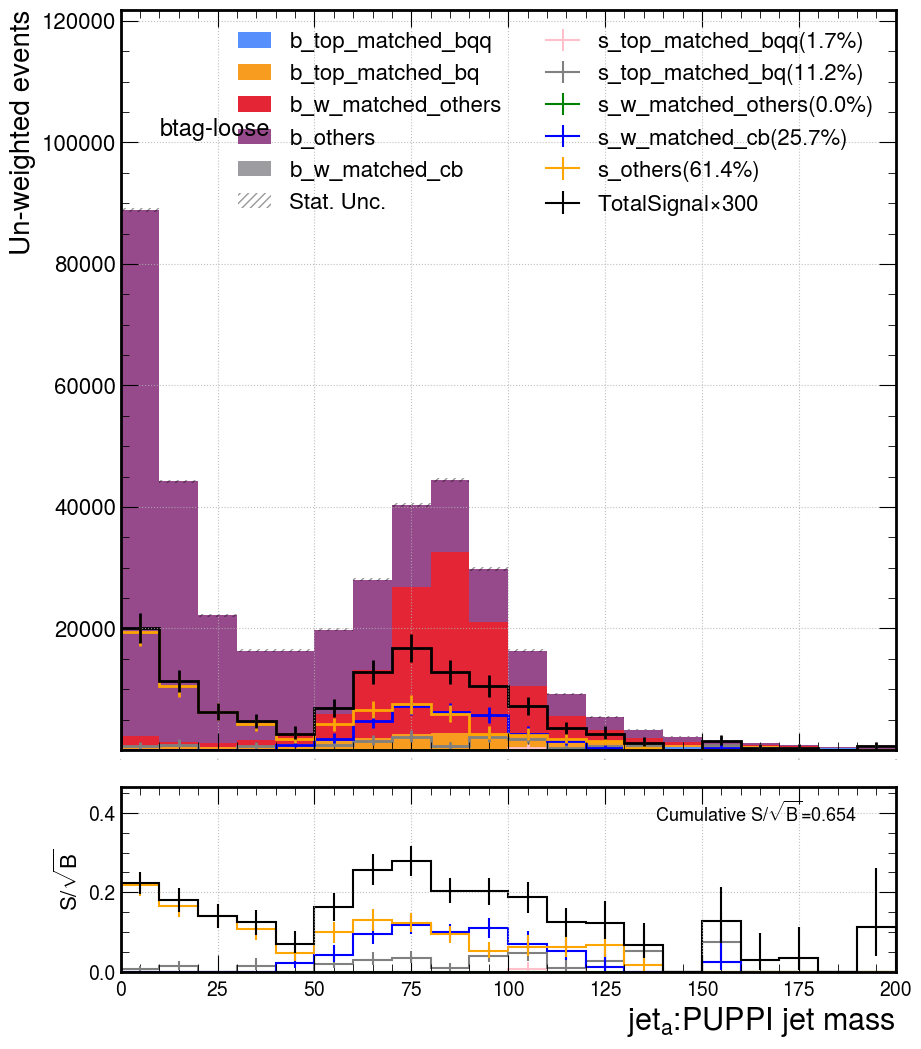

In [37]:
# run_makeplots(region = "PS",  blind = False,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "SR", blind = False,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "PS", blind = False,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "bveto", blind = False,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "SR2", blind = True,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "SR3", blind = True,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "CR",  blind = False,  othertext = "", deco = True) #this set to deco to True

# run_makeplots(region = "btag-tight",  blind = False,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "btag-medium", blind = False,  othertext = "", deco = True) #this set to deco to True
run_makeplots(region = "btag-loose",  blind = False,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "btag-ideal",  blind = False,  othertext = "", deco = True) #this set to deco to True

# run_makeplots(region = "b-tag SR1", blind = False,  othertext = "", deco = True) #this set to deco to True

# run_makeplots(region = "b-tag SR2", blind = False,  othertext = "", deco = True) #this set to deco to True

# run_makeplots(region = "ideal-SR1", blind = False,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "ideal-SR2", blind = False,  othertext = "", deco = True) #this set to deco to True

# run_makeplots(region = "loose-SR1", blind = False,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "loose-SR2", blind = False,  othertext = "", deco = True) #this set to deco to True

# run_makeplots(region = "medium-SR1", blind = False,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "medium-SR2", blind = False,  othertext = "", deco = True) #this set to deco to True

# run_makeplots(region = "tight-SR1", blind = False,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "tight-SR2", blind = False,  othertext = "", deco = True) #this set to deco to True

# run_makeplots(region = "ideal-SR1-dR", blind = False,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "ideal-SR2-dR", blind = False,  othertext = "", deco = True) #this set to deco to True

# run_makeplots(region = "tight-SR1-dR", blind = False,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "tight-SR2-dR", blind = False,  othertext = "", deco = True) #this set to deco to True

# run_makeplots(region = "loose-SR1-dR", blind = False,  othertext = "", deco = True) #this set to deco to True
# run_makeplots(region = "loose-SR2-dR", blind = False,  othertext = "", deco = True) #this set to deco to True
